In [1]:
import sys
import os
sys.path.append(os.path.join(os.path.abspath(''), '../..'))

In [2]:
############################
#region Arguments

import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=123, help='Random seed for model')
parser.add_argument('--dataset', type=str, default='cora', help='dataset')

parser.add_argument('--ptb_rate', type=float, default=0.25, help='Perturbation rate (percentage of available edges)')

parser.add_argument('--protect_size', type=float, default=0.1, help='Number of randomly chosen protected nodes')
parser.add_argument('--reg_epochs', type=int, default=100, help='Epochs to train models')
parser.add_argument('--ptb_epochs', type=int, default=30, help='Epochs to perturb adj matrix')

parser.add_argument('--save', type=str, default='N', help='save the outputs to csv')

args = parser.parse_args("")

#endregion
##########################

##########################
#region Environment

import torch
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

np.random.seed(args.seed)
torch.manual_seed(args.seed)

if device != 'cpu':
    torch.cuda.manual_seed(args.seed)

print(f'[i] Environment:  torch {torch.__version__} \tdevice: {device} \tseed: {args.seed}')

#endregion
##########################

########################
#region Data

from Utils import GraphData

print(f'[i] Dataset: {args.dataset}')

graph = GraphData.getGraph("../../Datasets", args.dataset, "gcn", args.seed, device)
graph.summarize()

#endregion
########################

[i] Environment:  torch 1.10.2 	device: cpu 	seed: 123
[i] Dataset: cora
Loading cora dataset...

[i] Dataset Summary: 
	adj shape: [2708, 2708]
	feature shape: [2708, 1433]
	num labels: 7
	split seed: 123
	train|val|test: 140|500|1000


In [3]:
########################
#region Feature Calculation

from Utils import FeatureMetrics

# print(graph.features)
transposed = graph.features.t().contiguous()
metrics = torch.zeros([2, transposed.shape[0]])

# Entropy of all features
for i in range(transposed.shape[0]):
    metrics[0][i] = FeatureMetrics.shannon_entropy(transposed[i])
    metrics[1][i] = FeatureMetrics.chi_squared(transposed[i], graph.labels)

#endregion
########################


IndexError: The shape of the mask [1433] at index 0 does not match the shape of the indexed tensor [2] at index 0

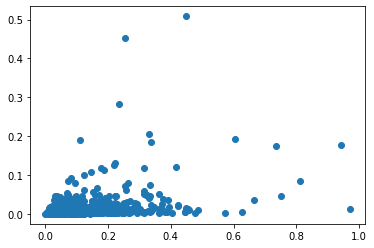

In [15]:
########################
#region Feature Selection
from Utils import FeatureMetrics

import matplotlib.pyplot as plt
plt.scatter(metrics[0], metrics[1])

idx_selected = FeatureMetrics.sample_by_quantiles(metrics[0], metrics[1])
# plt.scatter(metrics[], y)

#endregion
########################


In [14]:
tensor_a = metrics[0]
tensor_b = metrics[1]
n_bins = 4
n_samples = 100

assert tensor_a.shape[0] == tensor_b.shape[0]

dist = torch.zeros([2, tensor_a.shape[0]])
dist[0] = torch.bucketize(tensor_a, torch.arange(tensor_a.min(), tensor_a.max() - 0.000001, (tensor_a.max() - tensor_a.min()) / (n_bins - 1)))
dist[1] = torch.bucketize(tensor_b, torch.arange(tensor_b.min(), tensor_b.max() - 0.000001, (tensor_b.max() - tensor_b.min()) / (n_bins - 1)))

prob = torch.zeros([dist.shape[1]])
for i in range(n_bins):
    for j in range(n_bins):
        selected = (dist[0] == i) * (dist[0] == j)
        if selected.sum() == 0:
            prob[selected] = 0
        else:
            prob[selected] = 1 / selected.sum()

prob *= n_samples / prob.sum()
idx = torch.bernoulli(prob.clamp(0, 1)) == 1
idx

tensor([False, False, False,  ..., False, False, False])

In [ ]:
n_bins = 4
target_samples = 50
transposed = metrics.t()
dist = torch.zeros([transposed.shape[0] + 1, transposed.shape[1]])
dist[0] = transposed[0]
for i in range(1, transposed.shape[0]):
    met = transposed[i]
    row = torch.bucketize(met, torch.arange(met.min(), met.max() - 0.000001, (met.max() - met.min()) / (n_bins - 1)))
    dist[i] = row

for i in range(n_bins):
    for j in range(n_bins):
        selected = (dist[1] == i) * (dist[2] == j)
        if selected.sum() == 0:
            dist[-1][selected] = 0
        else:
            dist[-1][selected] = 1 / selected.sum()

dist[-1] *= 100 / dist[-1].sum()
idx = torch.bernoulli(dist[-1].clamp(0, 1)) == 1
idx
# row = transposed[1]
# entropy_bucket = torch.bucketize(row, torch.arange(row.min(), row.max() - 0.000001, (row.max() - row.min()) / (n_bins - 1)))
# chisq_bucket = torch.bucketize(row, boundaries)

tensor([False, False, False,  ..., False, False, False])

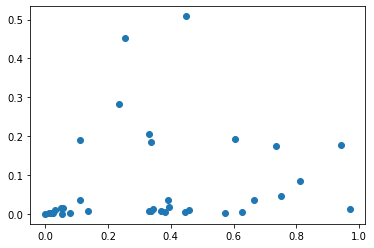

In [ ]:
select = t[:,idx]
plt.scatter(select[0], select[1])

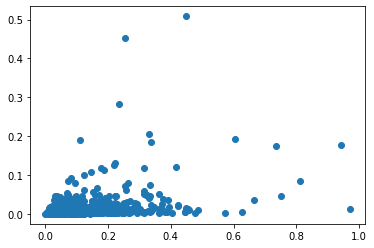

In [ ]:
import matplotlib.pyplot as plt
t = metrics.t()
plt.scatter(t[0], t[1])


In [ ]:
ax = plt.subplot()
ax.hist(t[0], bins=100)

plt.show()

KeyboardInterrupt: 